In [25]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr
import seaborn as sns
import tqdm
import scipy
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.optimize import minimize, Bounds
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/obs_summer.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/OBS_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_lowRes_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 2.91 seconds


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 10.85 seconds


In [27]:
def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 40)
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 125, 185, pre_mask = ocean)
indian_ocean = make_region_mask(-15, 10, 50, 100, pre_mask = ocean)
rest_ocean = np.logical_and(~warmpool, ocean)
ocean = make_region_mask(-30, 30, 0, 360, pre_mask = ocean)

# Build loss on overlap

In [28]:
import numpy as np
import warnings

def stipple_score_var_boundaries_on_jdist(self, var_id, func, normalized_boundary_list, mask, stipple_threshold=0.33):
    ## Prepare data
    key = func + '_' + var_id

    if func == 'MCS':
        da_var = self.grid.get_var_id_ds(self.st_label_var_id).sortby("days")[var_id]
    elif var_id == "Prec": 
        da_var = self.prec.sortby("days")[key]
    else:  
        da_var = self.grid.get_var_id_ds(var_id).sortby("days")[key]

    var_days = list(da_var.days.values)
    if isinstance(mask, np.ndarray):
        mask = mask[:, :, :len(var_days)]  # Adapt mask days length
    da_var = da_var.where(mask)
    min_var, max_var = np.min(da_var).values, np.max(da_var).values

    # Denormalize boundary list
    def denormalize(x, min_val, max_val):
        return x * (max_val - min_val) + min_val
    
    boundary_list = [denormalize(x, min_var, max_var) for x in normalized_boundary_list]
    boundaries = [min_var] + boundary_list + [max_var]
    reduced_prec = self.prec.sel(days=var_days)

    ## Compute conditionalized data
    bincount_where_var_cond = []
    for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]):
        spatial_var_where_cond = np.where((da_var.values > cond_inf) & (da_var.values <= cond_sup))
        sample1_where_cond = reduced_prec[self.var_id_1].where(mask).values[spatial_var_where_cond]  # This flattens
        sample2_where_cond = reduced_prec[self.var_id_2].where(mask).values[spatial_var_where_cond]  # This flattens
        bincount_cond, _, _ = np.histogram2d(x=sample1_where_cond, y=sample2_where_cond, bins=(self.bins1, self.bins2), density=False)
        bincount_where_var_cond.append(bincount_cond)

    ## Fetch prominent boundaries and compute density difference
    null = np.full_like(bincount_where_var_cond[0], 0)
    cond_stacked = np.stack([null] + bincount_where_var_cond)  # Add a null at the beginning
    cond_max = np.argmax(cond_stacked, axis=0)
    rows, cols = np.indices(cond_max.shape)
    temp_cond_stack = np.copy(cond_stacked)
    temp_cond_stack[cond_max, rows, cols] = -np.inf
    cond_max2 = np.argmax(temp_cond_stack, axis=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cond_max_diff = (cond_stacked[cond_max, rows, cols] - cond_stacked[cond_max2, rows, cols]) / np.sum(cond_stacked, axis=0)

    cond_max = cond_max.astype(float)
    cond_max_save = np.copy(cond_max)
    cond_max[cond_max == 0] = np.nan  # Now you can assign np.nan to it
    cond_max_big_diff = cond_max_diff[cond_max_diff < stipple_threshold]
    stipple_score = np.sum(cond_max_big_diff)

    ## Fair divide score
    fair_divide_score = 0
    average = np.mean([np.sum(cond_max_save == i + 1) for i in range(len(cond_stacked))])
    for i in range(len(cond_stacked)):
        fair_divide_score += np.abs(np.sum(cond_max_save == i + 1) - average)

    return stipple_score+fair_divide_score


In [29]:
def f(x,  prefered_value, weight, var_id="T2mm", func="mean", mask=True, stipple_threshold=0.5):
    cost = stipple_score_var_boundaries_on_jdist(jd, var_id = var_id, func = func, normalized_boundary_list=x, mask=ocean, stipple_threshold=stipple_threshold)
    penalty = weight*np.sum((x-prefered_value)**2)
    return cost+penalty

## MCS

In [31]:
initial_variables = np.array([0.03, 0.06, 0.12]) # Example starting values for x, y, and z
var_id = "growth_rate_surf_adj"
func  = 'MCS'
stipple_threshold=0.1

constraints = (
    {'type': 'ineq', 'fun': lambda variables: variables[1] - variables[0]},  # y - x > 0
    {'type': 'ineq', 'fun': lambda variables: variables[2] - variables[1]},  # z - y > 0
)

simple_bounds = [0, 1]
bounds = Bounds([simple_bounds[0], simple_bounds[0], simple_bounds[0]], [simple_bounds[1], simple_bounds[1], simple_bounds[1]])

result = minimize(fun=f, x0=initial_variables, args=(initial_variables, 1000, var_id, func, True, stipple_threshold), method='trust-constr', bounds=bounds, constraints=constraints, \
                  options = {'finite_diff_rel_step':1, 'gtol': 1e-8})
print(f"Optimal boundaries: {[r for r in result.x]}")
print(f"Minimum function value: {result.fun}")

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by

Optimal boundaries: [0.028070678965666358, 0.06150197094663205, 0.06170631820760734]
Minimum function value: 967.6792420141345


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [22]:
score = stipple_score_var_boundaries_on_jdist(jd, var_id, func, [0.08, 0.14, 0.3], True, stipple_threshold=0.2)
score

12.543140292962814

# DATAVIZ FOR HDBSCAN Clustering : Super hard
#### prepare data for var_id, func

In [99]:
## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

In [100]:
def get_da_from_var_id_func(var_id, func):    
    key = func+'_'+var_id
    if func == 'MCS':
        da_var = jd.grid.get_var_id_ds(jd.st_label_var_id).sortby("days")[var_id]
    # Trying to avoid the prec bug, maybe it's due to prec dataset already being open within jd
    elif var_id == "Prec" : 
        da_var = jd.prec.sortby("days")[key]
    else :  
        da_var = jd.grid.get_var_id_ds(var_id).sortby("days")[key]
    return da_var

In [101]:
var_id = "OM850_cond_Prec_lag_1"
# var_id="T2mm"
func = "mean"
da = get_da_from_var_id_func(var_id, func)
da_days = da.days
data = da.where(ocean).values.reshape(-1)
# Build scaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [102]:
data_prec_1 = jd.prec[jd.var_id_1].sel(days = da_days).where(ocean).values.reshape(-1)
data_prec_1[np.isnan(data_prec_1)]=0
df1 = pd.DataFrame({'Prec_1' : data_prec_1})
df1['Rank_1'] = df1['Prec_1'].rank(method='average')/len(df1['Prec_1'])
data_prec_1 = df1['Rank_1']


data_prec_2 = jd.prec[jd.var_id_2].sel(days = da_days).where(ocean).values.reshape(-1)
data_prec_2[np.isnan(data_prec_2)]=0
df2 = pd.DataFrame({'Prec_2' : data_prec_2})
df2['Rank_2'] = df2['Prec_2'].rank(method='average')/len(df2['Prec_2'])
data_prec_2 = df2['Rank_2']

In [103]:
inv_log_scale = True
if inv_log_scale : 
    data_prec_1 = np.log10(1/(1-data_prec_1))
    data_prec_2 = np.log10(1/(1-data_prec_2))

In [122]:
# rank_dry =90/scale
# bin_dry =90/scale
# dry_filter = np.logical_and(data_prec_1 > rank_dry, data_prec_2 >rank_dry)*

# rank_dry = 10
# dry1 = jd.dist1.bins[rank_dry]
# dry2 = jd.dist2.bins[rank_dry]
# dry_filter = np.logical_and(data_prec_1 > dry1 , data_prec_2 > dry2)

rank_dry = 1
dry_filter = np.logical_and(data_prec_1 > rank_dry , data_prec_2 > rank_dry)

In [128]:
X = np.vstack([data, data_prec_1, data_prec_2]).T
X = X[dry_filter]
X = X[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
X[:, 0] = scaler.fit_transform(X[:,0].reshape(-1, 1)).reshape(-1)
# X_min = X.min(axis=0)
# X_max = X.max(axis=0)
# X = (X - X_min) / (X_max - X_min)
weights = np.array([0.98, 0.01, 0.01])
X_3d = np.copy(X)
X = np.matmul(X, np.array([1, 0, 0])).reshape(-1, 1)

/scratchx/mcarenso/ipykernel_1300753/2583419709.py:11: RuntimeWarning:

invalid value encountered in matmul



In [129]:
import hdbscan
from scipy.spatial.distance import euclidean
from functools import partial
from scipy.spatial.distance import pdist, squareform

In [130]:
# Pass points
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=1, cluster_selection_epsilon=0.5)
cluster_labels = clusterer.fit_predict(X)


# #Build and pass distance_matrix
# distance_matrix = squareform(pdist(X, metric=euclidean_w))
# clusterer = hdbscan.HDBSCAN(metric='precomputed', 
#                             min_cluster_size=60, min_samples=3,
#                             cluster_selection_epsilon=0.5)
# cluster_labels = clusterer.fit_predict(distance_matrix)

In [131]:
clusters, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(clusters, counts):
    print(f"Cluster {cluster}: {count} elements")

Cluster -1: 5919 elements
Cluster 0: 15669 elements
Cluster 1: 1548 elements


In [132]:
import plotly.graph_objects as go
import numpy as np
# Assuming you have X and labels from your dataset and clustering
unique_labels = np.unique(clusterer.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
X = X_3d
fig = go.Figure()

for k in unique_labels:
    class_member_mask = (clusterer.labels_ == k)
    xy = X[class_member_mask]

    if k == -1:
        # Black used for noise
        col_rgb = 'rgb(0,0,0)'
    else:
        col = plt.cm.Spectral(k / len(unique_labels))
        col_rgb = f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})'

    fig.add_trace(go.Scatter3d(x=xy[:, 1], y=xy[:, 2], z=xy[:, 0],
                               mode='markers',
                               marker=dict(color=col_rgb, size=6, line=dict(color='black', width=1)),
                               name=f'Cluster {k}'))

fig.update_layout(title='Interactive 3D HDBSCAN Clustering',
                  scene=dict(zaxis_title='Scaled data',
                             xaxis_title='Mean Prec',
                             yaxis_title='km Prec',
                             aspectratio=dict(x=1, y=1, z=1)),
                            #  aspectmode='manual',
                            #  )
                             height=800, 
                             width=800)  

fig.show()


In [133]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

<AxesSubplot:ylabel='$\\lambda$ value'>

<AxesSubplot:ylabel='distance'>

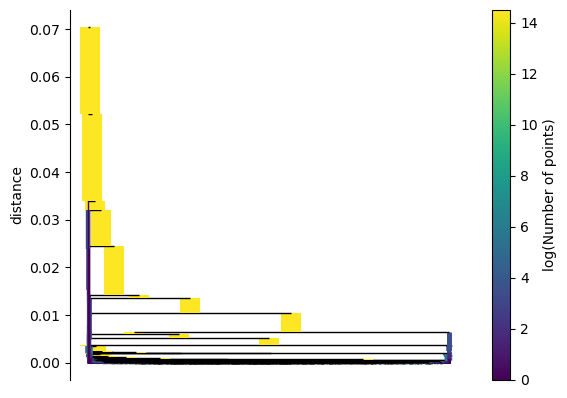

In [135]:
%matplotlib inline
clusterer.single_linkage_tree_.plot()

In [31]:
from sklearn.metrics import silhouette_score
# Define the range of parameters you want to search
min_cluster_size_range = [5, 10, 15]
min_samples_range = [5, 10, 15]
cluster_selection_epsilon_range = [0.0, 0.5, 1.0]

# Store the best configuration and its silhouette score
best_score = -1
best_params = {}

for min_cluster_size in tqdm.tqdm_notebook(min_cluster_size_range):
    for min_samples in tqdm.tqdm_notebook(min_samples_range):
        for cluster_selection_epsilon in tqdm.tqdm_notebook(cluster_selection_epsilon_range):
            # Configure the HDBSCAN model
            model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples,
                            cluster_selection_epsilon=cluster_selection_epsilon)
            
            # Fit the model
            model.fit(X)
            
            # Predict the labels (ignoring noise points labeled as -1)
            labels = model.labels_
            noise_mask = labels != -1
            
            # Evaluate only if there's more than one cluster (excluding noise) formed
            if len(set(labels[noise_mask])) > 1:
                score = silhouette_score(X[noise_mask], labels[noise_mask])
                
                # Update best parameters if current score is better
                if score > best_score:
                    best_score = score
                    best_params = {
                        'min_cluster_size': min_cluster_size,
                        'min_samples': min_samples,
                        'cluster_selection_epsilon': cluster_selection_epsilon
                    }

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

/scratchx/mcarenso/ipykernel_2744077/3894926751.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for min_cluster_size in tqdm.tqdm_notebook(min_cluster_size_range):


  0%|          | 0/3 [00:00<?, ?it/s]

/scratchx/mcarenso/ipykernel_2744077/3894926751.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for min_samples in tqdm.tqdm_notebook(min_samples_range):


  0%|          | 0/3 [00:00<?, ?it/s]

/scratchx/mcarenso/ipykernel_2744077/3894926751.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cluster_selection_epsilon in tqdm.tqdm_notebook(cluster_selection_epsilon_range):


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 